1.Import packages

In [4]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import random
import datetime
import time
#from zfel import sase1d_input_part
import sase1d_input_part
import torch
import torch.optim as optim

2.Input parameters

In [5]:
Nruns=1                             # Number of runs
npart   = 512                       # n-macro-particles per bucket 
s_steps = 31#200#31                    # n-sample points along bunch length
z_steps = 20#200#20                    # n-sample points along undulator
energy  = 4313.34*1E6               # electron energy [eV]
eSpread = 0#1.0e-4                  # relative rms energy spread [ ]
emitN   = 1.2e-6                    # normalized transverse emittance [m-rad]
currentMax = 3900                   # peak current [Ampere]
beta = 26                           # mean beta [meter]
unduPeriod = 0.03                   # undulator period [meter]
#unduK = 3.5                        # undulator parameter, K [ ]
unduK = np.ones(z_steps)*3.5  # tapered undulator parameter, K [ ]
if unduK.shape[0]!=z_steps:
    print('Wrong! Number of steps should always be the same as z_steps')
unduL = 70#30                       # length of undulator [meter]
radWavelength = 1.5e-9              # seed wavelength? [meter], used only in single-freuqency runs
dEdz = 0                            # rate of relative energy gain or taper [keV/m], optimal~130
iopt = 'sase'                       # 'sase' or 'seeded'
P0 = 10000*0.0                      # small seed input power [W]
constseed = 1                       # whether we want to use constant random seed for reproducibility, 1 Yes, 0 No
particle_position=genfromtxt('./Inputs/particle_position.csv', delimiter=',') # or None  
# particle information with positions in meter and eta,\
# if we want to load random particle positions and energy, then set None
hist_rule='square-root'             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                    #  of intervals to generate the histogram of eta value in a bucket

In [6]:
'''
Put input parameters into a inp_struct dict, for 1D FEL run
'''
inp_struct={'Nruns':Nruns,'npart':npart,'s_steps':s_steps,'z_steps':z_steps,'energy':energy,'eSpread':eSpread,\
            'emitN':emitN,'currentMax':currentMax,'beta':beta,'unduPeriod':unduPeriod,'unduK':unduK,'unduL':\
            unduL,'radWavelength':radWavelength,'dEdz':dEdz,'iopt':iopt,'P0':P0,'constseed':constseed,'particle_position':particle_position,'hist_rule':hist_rule}

3.1D FEL run

Method 1: allow exploring all taper values

In [65]:
%load_ext autoreload
%autoreload

unduK = np.ones(z_steps)*3.5 #np.arange(3.52,3.48,-0.04/(z_steps-1))#   # tapered undulator parameter, K [ ]
if unduK.shape[0]!=z_steps:
    print('Wrong! Number of steps should always be the same as z_steps')
unduK_1=torch.tensor(unduK[:int(z_steps/2)],dtype=torch.float64)
unduK_2=torch.tensor(unduK[int(z_steps/2):],dtype=torch.float64,requires_grad=True)
#unduK = torch.tensor(unduK, dtype=torch.float64, requires_grad=True)
#undu_K=torch.cat((unduK_1,unduK_2))
#params_K = unduK
#learning_rate = 5e-21
#optimizer = optim.SGD([unduK_2], lr=learning_rate)
lr = 5e-21*torch.arange(unduK_2.shape[0])**4
n_epochs = 3000
his_FEL_power=[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of sase1d_input_part failed: Traceback (most recent call last):
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/xiao/miniconda3/envs/gnn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in u

In [116]:
def training_loop(n_epochs, lr, unduK_1, unduK_2, his_FEL_power):
    for epoch in range(1, n_epochs + 1):
        print('epochs:',epoch)
        '''
        Use sase function in sase1d.py to run 1D FEL
        '''
        #with torch.autograd.set_detect_anomaly(True):
        #inp_struct['unduK']=params_K
        if unduK_2.grad is not None:
            unduK_2.grad.zero_()
        undu_K=torch.cat((unduK_1,unduK_2))
        inp_struct['unduK']=undu_K
        z,power_z,s,power_s,rho,detune,field,\
        field_s,gainLength,resWavelength,\
        thet_out,eta_out,bunching,spectrum,freq,\
        Ns,history=sase1d_input_part.sase(inp_struct)
        power_z[-1].backward()
        print('gradient',unduK_2.grad)
        unduK_2=(unduK_2 - lr * \
            unduK_2.grad).detach().requires_grad_()
        
        #optimizer.zero_grad()
        #power_z[-1].backward()
        #optimizer.step()
        #print('gradient',unduK_2.grad)
        
        his_FEL_power.append(power_z[-1].detach().numpy())
    undu_K=torch.cat((unduK_1,unduK_2))
    return undu_K, his_FEL_power

epochs: 1
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.5772e+19, -5.0989e+17, -2.7386e+17, -9.0223e+16,  4.7750e+16,
        -4.5824e+15, -1.9328e+15, -1.1399e+15,  9.1002e+13,  0.0000e+00],
       dtype=torch.float64)
epochs: 2
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.5025, 3.5219, 3.5365, 3.4389, 3.5143, 3.5125, 3.5137,
        3.4981, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-3.6170e+18,  3.4863e+18,  6.5433e+17,  5.3639e+16, -2.6594e+16,
        -1.8817e+16, -1.5253e+15, -9.5440e+14,  9.8209e+13,  9.4367e-04],
       dtype=torch.float64)
epochs: 3
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4851, 3.4696, 3.5148, 3

gradient tensor([ 6.1486e+17,  9.7897e+16, -7.2990e+16,  1.3512e+16,  5.6350e+16,
        -5.3210e+15, -1.6834e+15, -6.3885e+14, -8.8692e+13,  1.8216e-03],
       dtype=torch.float64)
epochs: 21
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4054, 3.4390, 3.2418, 3.5312, 3.6767, 3.6652, 3.5038,
        3.5067, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 5.4274e+18,  1.8529e+18, -7.2211e+17,  8.1284e+16,  3.1224e+16,
         1.3128e+16,  2.5793e+15, -5.9595e+14, -6.5140e+13,  1.3991e-03],
       dtype=torch.float64)
epochs: 22
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.3961, 3.4968, 3.2089, 3.4913, 3.6356, 3.6485, 3.5109,
        3.5080, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.6692e+18,  1.0738e+18, -4.8746e+17,  1.8536e+17, -1.0427e+17,
        -8.3757e+15, -5.7979e+14, -4.2415e+14,  2.6620e+14, 

gradient tensor([-2.2638e+17, -5.4737e+17,  1.0134e+17,  8.3278e+16,  2.5977e+16,
        -4.0498e+15, -3.1634e+15,  1.6375e+14, -2.3378e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 41
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4132, 4.0010, 2.9571, 3.8351, 3.7389, 3.6113, 3.4830,
        3.4950, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.1289e+19, -6.4480e+18, -1.6236e+18, -2.0958e+17,  1.9032e+17,
         5.0352e+15,  1.1599e+15,  6.7585e+13, -2.9769e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 42
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4454, 4.1309, 3.0420, 3.5915, 3.7231, 3.6038, 3.4822,
        3.5011, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.8888e+18, -3.7414e+18, -1.1986e+18, -3.4001e+17,  7.7307e+16,
        -2.0545e+16,  9.9311e+15, -6.4479e+13, -4.3088e+14, 

gradient tensor([-9.5149e+17,  8.8547e+17, -1.5831e+18, -5.2854e+17,  7.4067e+16,
         1.7724e+16, -3.2360e+13, -1.6211e+14, -1.7603e+14, -6.5785e-05],
       dtype=torch.float64)
epochs: 61
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.3625, 4.1954, 3.3722, 3.8803, 3.5557, 3.5129, 3.4727,
        3.5183, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.5674e+19, -5.1644e+18,  8.5617e+16, -2.7404e+17, -7.7263e+16,
         1.6877e+16, -8.9272e+14,  6.0162e+12,  1.6970e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 62
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.3883, 4.1886, 3.4832, 3.9792, 3.5030, 3.5187, 3.4726,
        3.5148, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 2.7920e+18,  1.6079e+18, -1.1243e+17, -2.2715e+16,  2.0026e+16,
         9.7213e+15,  2.5187e+15, -1.0186e+14, -9.2370e+13, 

gradient tensor([-1.9636e+19, -2.1914e+18,  6.4137e+16, -6.6127e+16, -2.4793e+16,
        -7.5799e+15, -4.0716e+15, -4.5538e+14, -7.1034e+13,  3.2893e-05],
       dtype=torch.float64)
epochs: 81
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4531, 4.3718, 2.9847, 4.0251, 3.3668, 3.5140, 3.4998,
        3.5102, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 3.2888e+18, -3.1932e+18, -3.8710e+17,  1.3703e+17,  1.0653e+16,
         9.4210e+15, -3.1489e+15, -1.5794e+15,  6.1387e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 82
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4691, 4.4028, 2.9292, 4.0114, 3.3374, 3.5344, 3.5187,
        3.4976, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-5.8028e+18,  3.8877e+18,  1.0504e+18,  2.4167e+17, -2.8643e+16,
         4.0556e+15, -2.7379e+15,  5.5618e+14,  9.7254e+13, 

gradient tensor([ 4.3179e+18,  7.8575e+17,  9.3868e+16, -5.4381e+16,  7.4645e+15,
         1.2395e+16, -9.5338e+13, -1.1674e+14,  1.9584e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 101
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4358, 4.1395, 3.0382, 4.0361, 3.3919, 3.5179, 3.5148,
        3.4948, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 6.5671e+18,  4.1486e+18, -9.5424e+17,  3.0680e+17,  9.4041e+16,
        -9.8934e+15, -3.0947e+15,  2.2817e+14, -2.6861e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 102
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4151, 4.2159, 2.9139, 3.9158, 3.4228, 3.5379, 3.5121,
        3.5003, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-9.2923e+17, -3.0927e+18, -4.3614e+16, -8.3176e+17,  4.0883e+16,
        -2.7053e+16, -9.1032e+14,  4.1026e+14, -2.1210e+14

gradient tensor([ 3.1313e+18,  1.7445e+18, -3.0213e+17,  4.2395e+16, -2.8984e+16,
         1.9139e+16,  2.1175e+15, -5.7992e+14,  2.6825e+13,  0.0000e+00],
       dtype=torch.float64)
epochs: 121
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4841, 4.3013, 3.9566, 4.3211, 3.7900, 3.6312, 3.4758,
        3.4872, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.2224e+19, -1.4267e+18,  3.4320e+17, -3.8510e+17, -1.1754e+17,
        -2.4553e+16,  1.6684e+15,  4.2683e+14,  1.0805e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 122
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4913, 4.2739, 4.1125, 4.4716, 3.8667, 3.6204, 3.4707,
        3.4849, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-5.7994e+18,  1.4882e+17, -4.4911e+15,  5.1405e+16,  2.2061e+16,
        -4.8253e+15,  9.5055e+14, -1.9394e+14, -1.7573e+14

gradient tensor([ 5.0600e+18,  7.0058e+18, -2.7723e+17,  7.1022e+16, -2.6499e+16,
        -1.1885e+16, -5.6268e+14, -2.1148e+15, -3.0409e+14, -1.8216e-03],
       dtype=torch.float64)
epochs: 141
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.5643, 4.6543, 3.6255, 4.7480, 4.0760, 3.6507, 3.4264,
        3.4918, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.7932e+19, -8.0928e+18, -6.2273e+17, -9.6471e+15,  1.2395e+16,
         8.8779e+15,  1.6386e+14,  3.3291e+14,  5.7737e+13,  1.8216e-03],
       dtype=torch.float64)
epochs: 142
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.6047, 4.7041, 3.6294, 4.7322, 4.0482, 3.6497, 3.4225,
        3.4906, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-6.3103e+18, -3.5042e+18,  6.4353e+17, -8.8044e+16, -5.9280e+16,
         2.4439e+16,  3.0990e+14,  3.9660e+14,  3.1437e+13

gradient tensor([ 2.4458e+19,  4.0895e+18,  2.0078e+17, -1.5106e+17,  1.6444e+16,
        -5.9345e+14,  9.3189e+14, -2.7478e+14, -2.6805e+14, -6.5785e-05],
       dtype=torch.float64)
epochs: 161
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.6715, 4.4947, 3.5359, 4.6485, 3.9377, 3.5481, 3.3267,
        3.5133, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.9870e+19,  5.7117e+17,  1.3544e+18, -1.5596e+17, -2.1159e+16,
         9.4425e+15, -8.2060e+14, -1.3514e+15,  6.7686e+13,  9.1078e-04],
       dtype=torch.float64)
epochs: 162
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.6687, 4.3863, 3.5991, 4.6756, 3.9082, 3.5534, 3.3429,
        3.5119, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.8869e+19, -2.5457e+18, -1.6358e+17, -7.2756e+16, -4.9213e+15,
         7.7336e+15,  1.3315e+15, -6.3298e+14,  1.3390e+14

gradient tensor([ 7.0835e+18,  2.3121e+17, -5.8752e+17, -7.1919e+17, -4.9061e+16,
         7.2490e+15, -6.4625e+14,  7.7184e+14,  2.3271e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 181
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4555, 3.6000, 4.0473, 4.7580, 4.0405, 3.5497, 3.3665,
        3.5038, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.1225e+19, -2.8371e+18, -5.4108e+17,  3.9380e+16,  1.7243e+16,
         1.2598e+16,  2.6594e+15,  1.8220e+14,  1.3588e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 182
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4697, 3.6433, 4.0314, 4.7360, 4.0011, 3.5324, 3.3643,
        3.5011, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.6999e+18, -1.7566e+18, -3.9901e+17,  3.2007e+16, -3.1271e+16,
        -4.9377e+15, -1.3913e+15, -5.3194e+13, -2.7605e+14

gradient tensor([ 4.7303e+18,  9.3938e+17, -1.9712e+17, -1.3201e+17, -4.5350e+16,
        -4.7517e+15,  4.7035e+14,  5.6775e+14,  1.8258e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 201
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.6813, 3.7569, 4.1878, 4.7173, 4.1527, 3.6396, 3.4220,
        3.5007, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.8371e+19, -1.1729e+19, -4.0823e+18, -3.0581e+17, -5.3198e+16,
        -1.8054e+16, -4.6262e+14,  3.4350e+14,  2.6941e+14,  1.7558e-03],
       dtype=torch.float64)
epochs: 202
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.7400, 4.0835, 4.3117, 4.7854, 4.2092, 3.6426, 3.4179,
        3.4952, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.2671e+19, -3.5691e+18,  2.5812e+16,  1.3752e+18,  1.0666e+17,
         7.8394e+15,  1.7978e+15,  5.0131e+14,  4.0627e+14

gradient tensor([-6.6569e+18,  1.4923e+19,  3.9702e+17,  3.5006e+17, -5.9237e+16,
        -2.3160e+16, -3.4624e+15, -3.5609e+14,  3.3053e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 221
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4955, 4.4877, 4.0177, 4.7657, 4.3165, 3.8003, 3.4230,
        3.4411, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.9829e+19, -1.0755e+19,  6.6260e+16,  3.8943e+17,  3.9581e+15,
         3.2871e+15, -1.0695e+15, -7.0369e+14, -7.9864e+13,  7.7921e-04],
       dtype=torch.float64)
epochs: 222
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.5493, 4.4824, 3.8599, 4.7606, 4.3062, 3.8072, 3.4315,
        3.4427, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.9248e+19, -8.2334e+18, -1.7617e+18, -4.7000e+17, -8.2873e+16,
        -1.7525e+16, -5.6552e+14, -6.8742e+14,  1.9546e+14

gradient tensor([ 9.2894e+17,  2.7061e+18, -2.1293e+17,  1.4084e+17,  1.4208e+16,
         1.0692e+16,  1.3850e+15, -9.4036e+13, -2.4779e+14,  1.8873e-03],
       dtype=torch.float64)
epochs: 241
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4458, 4.6844, 4.0741, 4.3758, 4.1318, 3.8192, 3.4244,
        3.3897, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.7093e+19, -9.4202e+18, -2.4427e+16, -8.5852e+17, -7.5176e+16,
         1.8200e+16,  1.8797e+15,  4.4345e+14, -3.5709e+13,  0.0000e+00],
       dtype=torch.float64)
epochs: 242
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.4929, 4.6863, 4.4218, 4.4720, 4.0749, 3.8070, 3.4191,
        3.3904, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.6467e+19,  2.2781e+18,  7.4465e+17, -1.3550e+16, -3.4876e+16,
         8.3166e+15,  1.0232e+15, -1.8184e+14, -2.0793e+13

gradient tensor([ 1.9983e+18,  3.7821e+17, -1.7585e+16, -1.0204e+15,  1.0149e+16,
         1.3903e+15, -1.2345e+15,  1.1800e+15,  3.0716e+14, -6.5785e-05],
       dtype=torch.float64)
epochs: 261
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.3399, 4.1909, 4.1336, 3.8525, 3.8726, 3.8736, 3.4303,
        3.3640, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.9371e+18, -2.0881e+18,  6.9750e+17, -4.9845e+16,  5.5816e+16,
         6.3122e+15, -3.0687e+15, -4.7125e+14,  1.3837e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 262
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.3503, 4.1351, 4.1538, 3.7810, 3.8528, 3.8935, 3.4359,
        3.3612, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.1407e+19,  6.1242e+18, -2.0773e+18,  7.1914e+17, -2.2197e+17,
         1.0320e+16, -2.9029e+15, -3.8256e+14,  4.0238e+14

gradient tensor([-1.7922e+19, -6.3287e+18, -2.4555e+17,  4.6666e+17,  6.4056e+16,
        -2.6478e+15, -4.6402e+15, -9.1052e+14,  2.5459e+13,  0.0000e+00],
       dtype=torch.float64)
epochs: 281
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.2697, 4.5265, 3.5077, 4.1223, 3.9193, 3.9323, 3.4389,
        3.3570, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.5662e+19, -4.8761e+18, -3.3168e+18, -4.6735e+17, -8.5133e+16,
         1.0431e+15, -3.8552e+14, -1.3116e+14, -4.7095e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 282
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.2941, 4.7918, 3.6970, 4.2313, 3.9160, 3.9348, 3.4405,
        3.3666, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 3.1172e+18,  4.7062e+18,  1.0099e+18,  2.1325e+17, -2.3911e+16,
         1.0148e+16, -5.5876e+14,  1.7301e+15, -5.3199e+13

gradient tensor([-7.3791e+16, -8.1391e+17,  4.3957e+17, -1.0915e+17, -1.8843e+16,
        -3.1004e+16,  1.1739e+15,  4.4343e+14,  2.7501e+11,  4.2250e-04],
       dtype=torch.float64)
epochs: 301
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.1560, 3.9795, 3.1986, 3.8604, 3.8335, 4.0519, 3.4544,
        3.3632, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.6869e+18,  5.7854e+18,  1.3838e+18,  3.7306e+17,  5.8651e+16,
        -1.4923e+16,  6.3681e+14,  4.6124e+14,  1.3101e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 302
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.1270, 3.8688, 3.0475, 3.7853, 3.8802, 4.0478, 3.4489,
        3.3605, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-5.0887e+18, -1.3061e+17, -1.3401e+17,  3.8259e+15, -2.0986e+16,
        -1.0834e+16, -9.5975e+14,  1.7584e+14, -8.7869e+13

gradient tensor([-1.0092e+18,  5.3413e+17, -4.9583e+17, -6.4905e+15, -9.6743e+15,
        -1.8125e+15,  1.2783e+15, -1.3911e+13, -1.5275e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 321
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0219, 3.9424, 3.1626, 4.0934, 4.0657, 4.0481, 3.4388,
        3.3611, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 7.5021e+17,  8.6194e+18, -7.4977e+17, -6.8680e+17, -1.3412e+17,
        -1.5938e+16,  4.3576e+14, -8.0263e+14,  1.3936e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 322
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9788, 4.0023, 3.4408, 4.2650, 4.1155, 4.0453, 3.4485,
        3.3583, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.8723e+18, -1.5250e+19,  1.1456e+18,  1.0426e+17, -5.3551e+16,
        -3.4704e+13, -1.8626e+15,  8.7945e+14,  6.0411e+13

gradient tensor([-3.2751e+18, -9.2040e+18,  7.5427e+17,  1.1500e+17,  2.0142e+15,
        -1.8690e+16, -6.1092e+15, -1.0506e+15,  2.4401e+14,  8.4499e-04],
       dtype=torch.float64)
epochs: 341
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.1647, 3.4497, 3.2539, 4.2743, 4.2690, 4.1413, 3.4263,
        3.3656, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.6607e+19,  5.0923e+17, -1.0499e+17,  2.5944e+17, -6.7559e+14,
        -1.7256e+16,  1.0310e+15,  1.3628e+14, -9.4970e+11,  0.0000e+00],
       dtype=torch.float64)
epochs: 342
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.1622, 3.4581, 3.1488, 4.2751, 4.3229, 4.1346, 3.4247,
        3.3656, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 3.2971e+19, -6.0183e+18, -6.8467e+17, -5.8889e+17, -6.7826e+16,
        -4.3116e+15, -7.8917e+14, -3.0813e+14,  1.1147e+14

gradient tensor([ 8.0404e+18,  4.3746e+18,  2.3246e+16, -2.5918e+17, -1.8317e+16,
         1.0761e+16, -2.4528e+15, -9.4437e+13, -1.0434e+14,  1.7558e-03],
       dtype=torch.float64)
epochs: 361
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0807, 3.0934, 2.7652, 4.2209, 4.2748, 4.0631, 3.4577,
        3.3865, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 3.3884e+18, -8.7586e+17, -3.8992e+16, -3.1534e+15, -9.9717e+15,
        -1.1444e+14,  3.2436e+14, -4.4640e+14,  1.8363e+14,  1.8216e-03],
       dtype=torch.float64)
epochs: 362
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0851, 3.0965, 2.7664, 4.2337, 4.2751, 4.0610, 3.4631,
        3.3827, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-8.2321e+18,  6.5785e+18,  3.0443e+18,  2.0047e+16, -3.2649e+16,
        -8.9972e+15,  3.5337e+15, -6.5676e+13,  6.0598e+14

gradient tensor([ 1.3891e+19,  9.2630e+17,  2.1334e+18,  3.4728e+17,  2.6279e+16,
        -8.6988e+15, -7.8926e+13,  2.6463e+14,  5.2326e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 381
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0018, 2.5141, 2.8264, 3.9608, 4.3592, 4.1195, 3.5066,
        3.3765, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.1888e+19,  1.6863e+18,  5.4224e+18, -4.7871e+16,  2.4905e+16,
        -2.0205e+15,  5.8146e+14,  8.6522e+14,  2.2576e+14,  2.7981e-03],
       dtype=torch.float64)
epochs: 382
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9934, 2.0803, 2.8458, 3.9289, 4.3655, 4.1158, 3.4962,
        3.3719, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 1.3683e+18, -5.0464e+17, -6.7024e+17, -2.9570e+17,  1.4067e+16,
         5.8934e+15,  2.4212e+15,  4.6017e+14,  1.1543e+14

gradient tensor([ 2.6256e+18,  1.2176e+18, -9.7383e+17, -3.4063e+17,  2.7581e+16,
         7.0433e+15, -2.4210e+15, -5.1044e+13,  2.8952e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 401
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0459, 2.0869, 3.2818, 3.6082, 4.1458, 4.2084, 3.4949,
        3.3446, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-5.0472e+18, -3.2661e+18, -1.7144e+17,  2.9779e+17, -3.9430e+16,
        -1.2889e+16,  9.1902e+13, -8.0365e+14, -2.0365e+14, -6.5785e-05],
       dtype=torch.float64)
epochs: 402
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0623, 2.1006, 3.1612, 3.6587, 4.1861, 4.2078, 3.5045,
        3.3488, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-7.2286e+18, -4.2037e+18, -5.4959e+18, -5.2685e+17,  1.1270e+17,
         1.1127e+16,  3.7337e+14, -2.6667e+14, -7.7694e+13

gradient tensor([ 2.0238e+18, -9.1392e+16,  2.5634e+17,  4.5966e+15,  2.7308e+16,
         2.9865e+15,  1.5681e+15, -6.3640e+14, -3.2614e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 421
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0658, 2.9238, 3.7422, 3.5298, 4.3468, 4.2381, 3.5238,
        3.3289, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-3.0880e+17, -7.6190e+17, -8.9861e+17, -2.2105e+17, -6.6503e+15,
         3.5020e+15,  9.9084e+14,  4.9282e+14,  2.6603e+13,  0.0000e+00],
       dtype=torch.float64)
epochs: 422
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.0696, 2.9957, 3.8318, 3.5384, 4.3359, 4.2316, 3.5179,
        3.3283, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 4.2662e+18,  3.9866e+18,  4.7080e+17, -1.9137e+16,  3.7480e+16,
        -1.0060e+15, -1.3759e+15,  8.6624e+14,  1.8402e+14

gradient tensor([-7.7722e+17,  2.9723e+18,  7.4299e+17,  5.3660e+16, -8.0544e+15,
        -2.7445e+15,  1.0095e+15, -2.0849e+12, -2.6098e+14,  1.3991e-03],
       dtype=torch.float64)
epochs: 441
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9825, 2.2544, 3.6050, 3.2970, 4.5410, 4.1729, 3.4987,
        3.3183, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-7.3573e+17,  1.8228e+18, -2.3399e+18, -5.5918e+17,  2.8765e+16,
         4.2850e+15, -1.6867e+14,  1.3749e+14,  1.3525e+14, -6.5785e-05],
       dtype=torch.float64)
epochs: 442
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9734, 2.4416, 3.8315, 3.2602, 4.5276, 4.1740, 3.4970,
        3.3156, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-2.5237e+18, -3.7231e+18, -1.7465e+18,  2.1124e+17,  6.1495e+16,
        -3.3302e+15,  4.3934e+14,  3.8174e+14, -1.4271e+14

gradient tensor([ 8.7661e+17, -2.2913e+17, -2.1869e+17, -7.9842e+16, -6.8450e+15,
        -9.2654e+15,  6.0117e+14, -1.9396e+14,  1.3182e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 461
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9562, 2.9784, 5.2539, 3.7600, 4.4844, 4.1703, 3.4775,
        3.2862, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([ 2.7742e+17, -1.8014e+18, -9.2240e+17,  8.8196e+16,  2.2404e+16,
        -4.6025e+15,  1.7279e+15,  2.7209e+14,  6.2222e+13,  1.7558e-03],
       dtype=torch.float64)
epochs: 462
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.9652, 3.0522, 5.2182, 3.7314, 4.4988, 4.1591, 3.4742,
        3.2849, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.2215e+19,  6.4234e+17, -1.6485e+18,  1.8394e+17, -1.5014e+16,
        -3.2852e+15, -1.3921e+15,  3.3068e+14, -1.7490e+14

gradient tensor([-5.4651e+18,  4.4971e+18, -1.7327e+18, -7.6799e+16, -3.7013e+14,
        -5.9490e+15, -3.2057e+15, -9.4503e+14,  1.4835e+14,  0.0000e+00],
       dtype=torch.float64)
epochs: 481
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.7361, 2.3377, 4.5863, 3.9081, 4.6126, 4.0386, 3.4454,
        3.2944, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-6.3573e+18,  2.5013e+18, -1.1761e+17, -5.1442e+16, -2.4531e+16,
         4.2631e+15, -2.6799e+15,  6.0431e+14, -3.4556e+14,  9.1078e-04],
       dtype=torch.float64)
epochs: 482
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 2.7236, 2.3471, 4.6071, 3.9395, 4.5993, 4.0560, 3.4381,
        3.3014, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-5.4871e+18, -1.0626e+18, -1.2529e+18, -1.6705e+17, -2.0457e+16,
        -3.0941e+15,  1.5794e+15,  1.7464e+14,  1.4394e+14

gradient tensor([-1.2425e+19, -3.1863e+17, -1.2032e+18, -1.3281e+17,  4.2167e+16,
         1.7055e+16, -1.3052e+15,  1.0599e+14, -4.2984e+14,  0.0000e+00],
       dtype=torch.float64)


NameError: name 'loss' is not defined

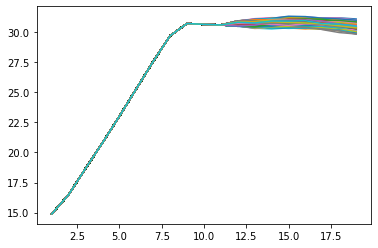

In [117]:
undu_K, his_FEL_power= training_loop(
    n_epochs = n_epochs,
    lr       = lr,
    #optimizer = optimizer,
    unduK_1 = unduK_1,
    unduK_2 = unduK_2,
    his_FEL_power = his_FEL_power)

Text(0.5, 1.0, 'output FEL power vs. epochs')

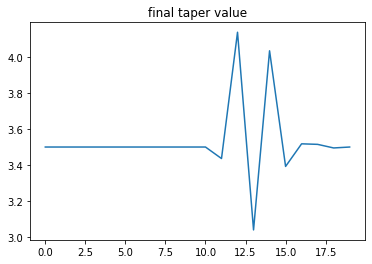

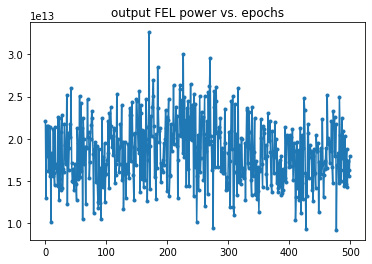

In [118]:
plt.figure()
plt.plot(undu_K.detach().numpy())
plt.title('final taper value')
plt.figure()
plt.plot(his_FEL_power,'.-')
plt.title('output FEL power vs. epochs')

Method 2: fit to quadratic taper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


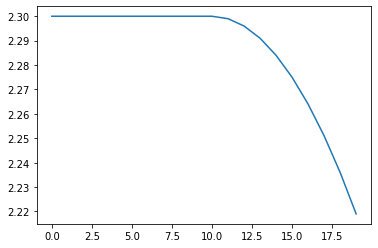

In [39]:
%load_ext autoreload
%autoreload


#params_K=torch.tensor([2.3,-0.001],requires_grad=True)
const_K=torch.tensor(2.3,requires_grad=True)
param_K=torch.tensor(-0.001,requires_grad=True)
lr_const = 1e-21 #1e-17
lr_param = 0#1e-21
#optimizer = optim.SGD([params_K], lr=learning_rate)
n_epochs = 100
his_FEL_power=[]
unduK_1=const_K*torch.ones(int(z_steps/2))
unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
undu_K=torch.cat((unduK_1,unduK_2))
plt.plot(undu_K.detach().numpy())

In [40]:
def training_loop(n_epochs, const_K, param_K, lr_const, lr_param, z_steps, his_FEL_power):
    for epoch in range(1, n_epochs + 1):
        print('epochs:',epoch)
        '''
        Use sase function in sase1d.py to run 1D FEL
        '''
        if const_K.grad is not None:
            const_K.grad.zero_()
        if param_K.grad is not None:
            param_K.grad.zero_()
        #sase1d_input_part.sase().zero_grad()
        #with torch.autograd.set_detect_anomaly(True):
        #inp_struct['unduK']=params_K
        #if unduK_2.grad is not None:
        #    unduK_2.grad.zero_()
        unduK_1=const_K*torch.ones(int(z_steps/2))
        unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
        undu_K=torch.cat((unduK_1,unduK_2))
        inp_struct['unduK']=undu_K
        z,power_z,s,power_s,rho,detune,field,\
        field_s,gainLength,resWavelength,\
        thet_out,eta_out,bunching,spectrum,freq,\
        Ns,history=sase1d_input_part.sase(inp_struct)
        
        
        #optimizer = optim.SGD([params_K], lr=lr)
        #optimizer.zero_grad()
        if epoch==1:
            (-power_z[-1]).backward(retain_graph=True)
        else:
            (-power_z[-1]).backward()
        print('gradient',const_K.grad,param_K.grad)
        const_K=(const_K + lr_const * const_K.grad).detach().requires_grad_()
        param_K=(param_K + lr_param * param_K.grad).detach().requires_grad_()
        #optimizer.step()
        
        print('power',power_z[-1])
        
        his_FEL_power.append(power_z[-1].detach().numpy())
    unduK_1=const_K*torch.ones(int(z_steps/2))
    unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
    undu_K=torch.cat((unduK_1,unduK_2))
    return undu_K, his_FEL_power

epochs: 1
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(4.3766e+15) tensor(3.1394e+15)
power tensor(3.5975e+13, grad_fn=<SelectBackward>)
epochs: 2
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(5.7660e+15) tensor(-1.2661e+18)
power tensor(3.5944e+13, grad_fn=<SelectBackward>)
epochs: 3
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(7.0517e+15) tensor(-5.5647e+17)
power tensor(3.5896e+13, grad_fn=<SelectBackward>)
epochs: 4
undu tensor([2.3000, 2.30

gradient tensor(-1.0194e+15) tensor(-1.2891e+17)
power tensor(3.5445e+13, grad_fn=<SelectBackward>)
epochs: 27
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(-1.8441e+15) tensor(-7.3328e+17)
power tensor(3.5434e+13, grad_fn=<SelectBackward>)
epochs: 28
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(1.6501e+15) tensor(-2.2888e+17)
power tensor(3.5416e+13, grad_fn=<SelectBackward>)
epochs: 29
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(1.1658e+15) t

gradient tensor(1.6501e+15) tensor(-2.2888e+17)
power tensor(3.5416e+13, grad_fn=<SelectBackward>)
epochs: 53
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(1.1658e+15) tensor(-3.2706e+17)
power tensor(3.5437e+13, grad_fn=<SelectBackward>)
epochs: 54
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(-1.0194e+15) tensor(-1.2891e+17)
power tensor(3.5445e+13, grad_fn=<SelectBackward>)
epochs: 55
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(-1.8441e+15) t

gradient tensor(-1.0194e+15) tensor(-1.2891e+17)
power tensor(3.5445e+13, grad_fn=<SelectBackward>)
epochs: 79
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(-1.8441e+15) tensor(-7.3328e+17)
power tensor(3.5434e+13, grad_fn=<SelectBackward>)
epochs: 80
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(1.6501e+15) tensor(-2.2888e+17)
power tensor(3.5416e+13, grad_fn=<SelectBackward>)
epochs: 81
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(1.1658e+15) t

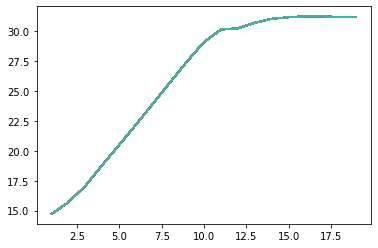

In [41]:
undu_K, his_FEL_power= training_loop(
    n_epochs = n_epochs,
    const_K = const_K,
    param_K = param_K,
    lr_const = lr_const,
    lr_param = lr_param,
    z_steps = z_steps,
    his_FEL_power = his_FEL_power)

Text(0.5, 1.0, 'output FEL power vs. epochs')

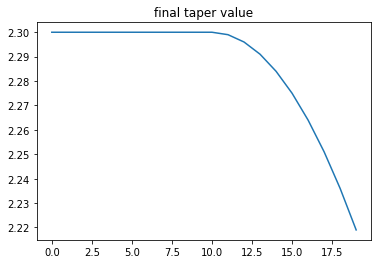

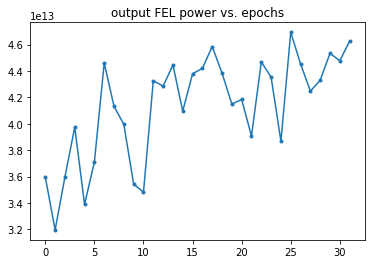

In [38]:
plt.figure()
plt.plot(undu_K.detach().numpy())
plt.title('final taper value')
plt.figure()
plt.plot(his_FEL_power,'.-')
plt.title('output FEL power vs. epochs')